In [4]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi

In [2]:
#%pip install celltypist scvi-tools hyperopt "ray[tune]" anndata2ri

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# Creating celltypist models

In [3]:
import celltypist
from celltypist import models

In [6]:
#models.get_all_models()

In [17]:
rdatas = []
for dem in [x for x in os.listdir('ref_data/') if 'dem' in x]:
    basename = dem.split('.')[0]
    samp = basename.split('_')[1]
    anno = [x for x in os.listdir('ref_data/') if samp == x.split('_')[1].split('.')[0] and 'anno' in x][0]

    temp_data = sc.read_text('ref_data/' + dem).T
    temp_anno = pd.read_table('ref_data/' + anno, index_col=0)[['CellType']]
    temp_data.obs = temp_data.obs.merge(right = temp_anno, left_index=True, right_index=True)

    temp_data.obs['ID'] = basename
    rdatas.append(temp_data)

In [18]:
rdata = sc.concat(rdatas)

In [17]:
rdata.obs.groupby('CellType').size()

CellType
B                520
CTL             1338
GMP              918
GMP-like        3055
HSC             1709
HSC-like        1979
Mono            2758
Mono-like       2655
NK              1969
Plasma          1146
ProB             298
ProMono         1146
ProMono-like    1917
Prog            1709
Prog-like       4438
T               7105
cDC              849
cDC-like        2125
earlyEry        1119
lateEry         1329
pDC              225
dtype: int64

In [19]:
sc.pp.filter_genes(rdata, min_cells = 10)

In [19]:
sc.pp.normalize_total(rdata, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
sc.pp.log1p(rdata)

In [21]:
rdata.obs

CellType                     ID
AML419A-D0_AAACCTCAGCTG  Mono-like  GSM3587950_AML419A-D0
AML419A-D0_AACAATTTCCTN  Mono-like  GSM3587950_AML419A-D0
AML419A-D0_AACACCGTAACG  Prog-like  GSM3587950_AML419A-D0
AML419A-D0_AACATCGTGCAN   GMP-like  GSM3587950_AML419A-D0
AML419A-D0_AACATTCGTGAG  Mono-like  GSM3587950_AML419A-D0
...                            ...                    ...
AML556-D15_TTTTGTAAGCAC        CTL  GSM3587965_AML556-D15
AML556-D15_TTTTGTCAGAGN        CTL  GSM3587965_AML556-D15
AML556-D15_TTTTTCTTTGAG         NK  GSM3587965_AML556-D15
AML556-D15_TTTTTGCCAGCG         NK  GSM3587965_AML556-D15
AML556-D15_TTTTTGGAGAAN          T  GSM3587965_AML556-D15

[41090 rows x 2 columns]

In [20]:
rdata = rdata[~rdata.obs.CellType.isna()]

In [24]:
rdata

View of AnnData object with n_obs × n_vars = 40307 × 19616
    obs: 'CellType', 'ID'
    var: 'n_cells'
    uns: 'log1p'

In [25]:
ref_model = celltypist.train(rdata, labels = 'CellType', n_jobs = 22,
                            use_SGD = False,
                            feature_selection = True, top_genes = 300)

🍳 Preparing data before training
🔬 Input data has 40307 cells and 19616 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2517 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [26]:
ref_model.write('/home/mark/.celltypist/data/models/ref.pkl')

In [21]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

cffi mode is CFFI_MODE.ANY
R home found: /usr/lib/R
R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
Default options to initialize R: rpy2, --quiet, --no-save
R is already initialized. No need to initialize.
/tmp/ipykernel_12404/2133713794.py:2: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [1]:
%%R
install.packages('Seurat')
BiocManager::install("SummarizedExperiment")

In [2]:
%%R
library(Seurat)
library(SummarizedExperiment)

In [23]:
%%R -o healthy

rse <- readRDS("ref_data2/scRNA-Healthy-Hematopoiesis-191120.rds")

seurat_object <- CreateSeuratObject(counts = assay(rse, "counts"), meta.data = as.data.frame(colData(rse)))

healthy <- as.SingleCellExperiment(seurat_object)

In addition: Warning messages:
1: Layer ‘data’ is empty 
2: Layer ‘scale.data’ is empty 


In [35]:
healthy.obs

orig.ident  nCount_RNA  \
CD34_32_R5:AAACCTGAGTATCGAA-1                    CD34      8303.0   
CD34_32_R5:AAACCTGAGTCGTTTG-1                    CD34      3917.0   
CD34_32_R5:AAACCTGGTTCCACAA-1                    CD34      6023.0   
CD34_32_R5:AAACGGGAGCTTCGCG-1                    CD34      4493.0   
CD34_32_R5:AAACGGGAGGGAGTAA-1                    CD34      5190.0   
...                                               ...         ...   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTAGTAG-1       BMMC      5240.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTCATGC-1       BMMC      1338.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCAGTGGTGA-1       BMMC      1660.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATGTGTCA-1       BMMC      1631.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATTGAAAG-1       BMMC      1665.0   

                                            nFeature_RNA      Group  nUMI_pre  \
CD34_32_R5:AAACCTGAGTATCGAA-1                       3187  CD34_D2T1   17876.0   
CD34_32_R5:AAACCTGAGTCGTTTG-1                       1787  CD34_D2T1    9277.0   
CD34_32_R5:AAACCTGGTTCCACAA-1                       2552  CD34_D2T1   13073.0   
CD34_32_R5:AAACGGGAGCTTCGCG-1                       2191  CD34_D2T1    8412.0   
CD34_32_R5:AAACGGGAGGGAGTAA-1                       2322  CD34_D2T1   11914.0   
...                                                  ...        ...       ...   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTAGTAG-1          2377  BMMC_D1T2    7515.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTCATGC-1           882  BMMC_D1T2    1597.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCAGTGGTGA-1          1004  BMMC_D1T2    2831.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATGTGTCA-1           951  BMMC_D1T2    2852.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATTGAAAG-1           963  BMMC_D1T2    2759.0   

                                              nUMI   nGene initialClusters  \
CD34_32_R5:AAACCTGAGTATCGAA-1               8303.0  3187.0        Cluster1   
CD34_32_R5:AAACCTGAGTCGTTTG-1               3917.0  1787.0        Cluster2   
CD34_32_R5:AAACCTGGTTCCACAA-1               6023.0  2552.0        Cluster3   
CD34_32_R5:AAACGGGAGCTTCGCG-1               4493.0  2191.0        Cluster4   
CD34_32_R5:AAACGGGAGGGAGTAA-1               5190.0  2322.0        Cluster3   
...                                            ...     ...             ...   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTAGTAG-1  5240.0  2377.0        Cluster9   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTCATGC-1  1338.0   882.0       Cluster16   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCAGTGGTGA-1  1660.0  1004.0       Cluster22   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATGTGTCA-1  1631.0   951.0       Cluster26   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATTGAAAG-1  1665.0   963.0       Cluster12   

                                               UMAP1      UMAP2   Clusters  \
CD34_32_R5:AAACCTGAGTATCGAA-1              -6.113410   4.616498   Cluster5   
CD34_32_R5:AAACCTGAGTCGTTTG-1              -8.800932  -1.228907   Cluster8   
CD34_32_R5:AAACCTGGTTCCACAA-1              -9.723482   7.335178   Cluster1   
CD34_32_R5:AAACGGGAGCTTCGCG-1              -4.293071   5.692705   Cluster6   
CD34_32_R5:AAACGGGAGGGAGTAA-1              -7.989706   9.108693   Cluster1   
...                                              ...        ...        ...   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTAGTAG-1 -5.708933  -2.843953   Cluster7   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTCATGC-1 -2.258849 -10.712415  Cluster12   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCAGTGGTGA-1  4.987181  -8.794110  Cluster19   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATGTGTCA-1  6.086861  -3.454188  Cluster20   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATTGAAAG-1  1.101248  12.074113  Cluster17   

                                           BioClassification  \
CD34_32_R5:AAACCTGAGTATCGAA-1                    05_CMP.LMPP   
CD34_32_R5:AAACCTGAGTCGTTTG-1                    08_GMP.Neut   
CD34_32_R5:AAACCTGGTTCCACAA-1                         01_HSC   
CD34_32_R5:AAACGGGAGCTTCGCG-1                       06_CLP.1   
CD34_32_R5:AAACGGGAGGGAGTAA-1                  

In [36]:
sc.pp.normalize_total(healthy, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
sc.pp.log1p(healthy)

In [37]:
ref2_model = celltypist.train(healthy, labels = 'BioClassification', n_jobs = 22,
                            use_SGD = False,
                            feature_selection = True, top_genes = 300)

🍳 Preparing data before training
✂️ 3368 non-expressed genes are filtered out
🔬 Input data has 35582 cells and 16919 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2860 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [38]:
ref2_model.write('/home/mark/.celltypist/data/models/ref2.pkl')

In [4]:
ref_model = models.Model.load(model="ref.pkl")
ref2_model = models.Model.load(model="ref2.pkl")
model_low = models.Model.load(model="Immune_All_Low.pkl")

In [5]:
def predict_cells(adata):
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.normalize_total(adata, target_sum=1e4) #not recommended for typical pp
    sc.pp.log1p(adata)

    adata.X = adata.X.toarray()

    predictions = celltypist.annotate(adata, model=model_low, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["low_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["low_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    predictions = celltypist.annotate(adata, model=ref_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["ref_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["ref_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    predictions = celltypist.annotate(adata, model=ref2_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["ref2_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["ref2_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    return adata.obs
    


In [6]:
adatas = [sc.read_h5ad('pp_adata/' + x) for x in os.listdir('pp_adata')]

In [8]:
len(adatas)

75

In [3]:
predictions = [predict_cells(ad.copy()) for ad in adatas]

In [11]:
predictions = pd.concat(predictions)[['low_label', 'low_score', 'ref_label', 'ref_score', 'ref2_label', 'ref2_score']]

predictions

low_label  low_score  \
AGGCCACTCGAACCTA-1-AML19_REL  Neutrophil-myeloid progenitor   0.030015   
AACGTCACATGACGAG-1-AML19_REL  Neutrophil-myeloid progenitor   0.227245   
CATGCCTGTCCGGTCA-1-AML19_REL                  Mid erythroid   0.993374   
CTCACTGAGATACAGT-1-AML19_REL                    Macrophages   0.204163   
GATCGTAAGGCAGGTT-1-AML19_REL  Neutrophil-myeloid progenitor   0.155923   
...                                                     ...        ...   
GGTTAACTCAGACTGT-1-AML26_REL    Tem/Temra cytotoxic T cells   0.984860   
TCACGCTAGACATAAC-1-AML26_REL                 CD16+ NK cells   0.400283   
TGTAAGCGTTGTGCCG-1-AML26_REL                             DC   0.105715   
CGGGACTTCACCTCGT-1-AML26_REL            Classical monocytes   0.347877   
CTCCGATTCTGGGTCG-1-AML26_REL                            ETP   0.066135   

                              ref_label  ref_score      ref2_label  ref2_score  
AGGCCACTCGAACCTA-1-AML19_REL   cDC-like   0.843493          07_GMP    0.003871  
AACGTCACATGACGAG-1-AML19_REL  Prog-like   0.100215     05_CMP.LMPP    0.999986  
CATGCCTGTCCGGTCA-1-AML19_REL    lateEry   0.999993   03_Late.Eryth    1.000000  
CTCACTGAGATACAGT-1-AML19_REL   cDC-like   0.999983          07_GMP    0.858804  
GATCGTAAGGCAGGTT-1-AML19_REL   GMP-like   0.039463     05_CMP.LMPP    0.999619  
...                                 ...        ...             ...         ...  
GGTTAACTCAGACTGT-1-AML26_REL         NK   1.000000       24_CD8.CM    0.777919  
TCACGCTAGACATAAC-1-AML26_REL   HSC-like   0.003593     08_GMP.Neut    0.032444  
TGTAAGCGTTGTGCCG-1-AML26_REL     Plasma   0.009472  11_CD14.Mono.1    0.001033  
CGGGACTTCACCTCGT-1-AML26_REL   HSC-like   0.114122  11_CD14.Mono.1    0.000027  
CTCCGATTCTGGGTCG-1-AML26_REL        HSC   0.985449  02_Early.Eryth    0.000099  

[300349 rows x 6 columns]

In [12]:
adata = sc.concat(adatas)

In [14]:
predictions.to_csv('PREDICTIONS.csv')

In [13]:
adata

AnnData object with n_obs × n_vars = 300349 × 33538
    obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'doublet_score'

In [15]:
adata.obs

Patient   DX     Sample  n_genes  \
AGGCCACTCGAACCTA-1-AML19_REL   AML19  REL  AML19_REL     7473   
AACGTCACATGACGAG-1-AML19_REL   AML19  REL  AML19_REL     7105   
CATGCCTGTCCGGTCA-1-AML19_REL   AML19  REL  AML19_REL     6142   
CTCACTGAGATACAGT-1-AML19_REL   AML19  REL  AML19_REL     7125   
GATCGTAAGGCAGGTT-1-AML19_REL   AML19  REL  AML19_REL     6876   
...                              ...  ...        ...      ...   
GGTTAACTCAGACTGT-1-AML26_REL   AML26  REL  AML26_REL     1016   
TCACGCTAGACATAAC-1-AML26_REL   AML26  REL  AML26_REL     1100   
TGTAAGCGTTGTGCCG-1-AML26_REL   AML26  REL  AML26_REL     1221   
CGGGACTTCACCTCGT-1-AML26_REL   AML26  REL  AML26_REL     1198   
CTCCGATTCTGGGTCG-1-AML26_REL   AML26  REL  AML26_REL     1267   

                              n_genes_by_counts  log1p_n_genes_by_counts  \
AGGCCACTCGAACCTA-1-AML19_REL               7473                 8.919186   
AACGTCACATGACGAG-1-AML19_REL               7105                 8.868695   
CATGCCTGTCCGGTCA-1-AML19_REL               6142                 8.723069   
CTCACTGAGATACAGT-1-AML19_REL               7125                 8.871505   
GATCGTAAGGCAGGTT-1-AML19_REL               6876                 8.835938   
...                                         ...                      ...   
GGTTAACTCAGACTGT-1-AML26_REL               1016                 6.924612   
TCACGCTAGACATAAC-1-AML26_REL               1100                 7.003974   
TGTAAGCGTTGTGCCG-1-AML26_REL               1221                 7.108244   
CGGGACTTCACCTCGT-1-AML26_REL               1198                 7.089243   
CTCCGATTCTGGGTCG-1-AML26_REL               1267                 7.145196   

                              total_counts  log1p_total_counts  \
AGGCCACTCGAACCTA-1-AML19_REL       67223.0           11.115786   
AACGTCACATGACGAG-1-AML19_REL       64416.0           11.073133   
CATGCCTGTCCGGTCA-1-AML19_REL       57582.0           10.960983   
CTCACTGAGATACAGT-1-AML19_REL       54708.0           10.909784   
GATCGTAAGGCAGGTT-1-AML19_REL       52846.0           10.875156   
...                                    ...                 ...   
GGTTAACTCAGACTGT-1-AML26_REL        2232.0            7.711101   
TCACGCTAGACATAAC-1-AML26_REL        2221.0            7.706163   
TGTAAGCGTTGTGCCG-1-AML26_REL        2286.0            7.734996   
CGGGACTTCACCTCGT-1-AML26_REL        2216.0            7.703910   
CTCCGATTCTGGGTCG-1-AML26_REL        2222.0            7.706613   

                              pct_counts_in_top_20_genes  pct_counts_mt  \
AGGCCACTCGAACCTA-1-AML19_REL                   15.725273       6.877111   
AACGTCACATGACGAG-1-AML19_REL                   17.413376       7.959203   
CATGCCTGTCCGGTCA-1-AML19_REL                   26.296412       5.861207   
CTCACTGAGATACAGT-1-AML19_REL                   19.775901       6.607809   
GATCGTAAGGCAGGTT-1-AML19_REL                   17.195247       6.764940   
...                                                  ...            ...   
GGTTAACTCAGACTGT-1-AML26_REL                   24.955197       4.480287   
TCACGCTAGACATAAC-1-AML26_REL                   24.358397       7.384061   
TGTAAGCGTTGTGCCG-1-AML26_REL                   18.197725       7.655293   
CGGGACTTCACCTCGT-1-AML26_REL                   20.532491      10.063177   
CTCCGATTCTGGGTCG-1-AML26_REL                   15.346535       5.535554   

                              pct_counts_ribo  pct_counts_hb  doublet  \
AGGCCACTCGAACCTA-1-AML19_REL        24.531782       0.011901      0.0   
AACGTCACATGACGAG-1-AML19_REL        25.009314       0.006210      0.0   
CATGCCTGTCCGGTCA-1-AML19_REL        21.247959      15.508319      0.0   
CTCACTGAGATACAGT-1-AML19_REL        20.391899       0.036558      0.0   
GATCGTAAGGCAGGTT-1-AML19_REL        27.057866       0.009461      0.0   
...                                       ...            ...      ...   
GGTTAACTCAGACTGT-1-AML26_REL        23.700717       0.000000      0.0   
TCACGCTAGACATAAC-1-AML26_REL        23.277803       0.045

# scVI label transfer

In [16]:
adata.obs['CellType'] = 'Unknown'
adata.obs['Batch'] = 'AML'

In [ ]:
##### healthy and rdata needs to be reloaded because it was normalized earlier !!!!!!!!!!

In [25]:
healthy.obs['CellType'] = healthy.obs['BioClassification']
healthy.obs['Batch'] = 'ref2'
healthy.obs['Sample'] = healthy.obs.index.map(lambda x: x.split(':')[0])

In [26]:
rdata.obs['Batch'] = 'ref'
rdata.obs['Sample'] = rdata.obs['ID']

In [27]:
dater = sc.concat((adata, healthy, rdata))

In [29]:
sc.pp.highly_variable_genes(dater, flavor = 'seurat_v3', n_top_genes=2000, batch_key="Batch", subset = True)

In [30]:
dater

AnnData object with n_obs × n_vars = 376238 × 2000
    obs: 'Sample', 'CellType', 'Batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'

In [32]:
import scvi

In [33]:
scvi.model.SCVI.setup_anndata(dater, batch_key='Batch', categorical_covariate_keys = ['Sample'])
vae = scvi.model.SCVI(dater)
vae.train()

Unable to initialize backend 'cuda': 
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
INFO: GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs

Epoch 21/21: 100%|█| 21/21 [03:16<00:00,  9.27s/it, v_num=1, train_loss_step=587

INFO: `Trainer.fit` stopped: `max_epochs=21` reached.
`Trainer.fit` stopped: `max_epochs=21` reached.


Epoch 21/21: 100%|█| 21/21 [03:16<00:00,  9.38s/it, v_num=1, train_loss_step=587


In [34]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = dater, unlabeled_category = 'Unknown',
                                        labels_key = 'CellType')

lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|█| 20/20 [07:25<00:00, 22.52s/it, v_num=1, train_loss_step=589

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [07:25<00:00, 22.28s/it, v_num=1, train_loss_step=589


In [38]:
dater.obs['predicted'] = lvae.predict(dater)

In [39]:
dater.obs['transfer_score'] = lvae.predict(soft = True).max(axis = 1)

In [40]:
dater = dater[dater.obs.Batch == 'AML']

In [41]:
dater

View of AnnData object with n_obs × n_vars = 300349 × 2000
    obs: 'Sample', 'CellType', 'Batch', '_scvi_batch', '_scvi_labels', 'predicted', 'transfer_score'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs'

In [44]:
adata.obs = adata.obs.merge(right = dater.obs[['predicted', 'transfer_score']], left_index=True, right_index=True)

In [46]:
adata.obs = adata.obs.merge(right = predictions, left_index=True, right_index=True)

In [48]:
adata.write_h5ad('unintigrated.h5ad')

... storing 'CellType' as categorical
... storing 'Batch' as categorical
... storing 'predicted' as categorical
... storing 'low_label' as categorical
... storing 'ref_label' as categorical
... storing 'ref2_label' as categorical


In [3]:
adata = sc.read('unintigrated.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 300349 × 33538
    obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'doublet_score', 'CellType', 'Batch', 'predicted', 'transfer_score', 'low_label', 'low_score', 'ref_label', 'ref_score', 'ref2_label', 'ref2_score'

# Integration

In [5]:
from scvi.autotune import ModelTuner
from ray import tune

In [6]:
sc.pp.filter_genes(adata, min_cells = 50)

In [7]:
adata

AnnData object with n_obs × n_vars = 300349 × 21156
    obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'doublet_score', 'CellType', 'Batch', 'predicted', 'transfer_score', 'low_label', 'low_score', 'ref_label', 'ref_score', 'ref2_label', 'ref2_score'
    var: 'n_cells'

In [8]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, categorical_covariate_keys = ['Sample'],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])

tuner = ModelTuner(model_cls)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [9]:
tuner.info()

ModelTuner registry for SCVI

                  Tunable hyperparameters                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃      Hyperparameter      ┃ Default value ┃    Source    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│         n_hidden         │      128      │     VAE      │
│         n_latent         │      10       │     VAE      │
│         n_layers         │       1       │     VAE      │
│       dropout_rate       │      0.1      │     VAE      │
│        dispersion        │     gene      │     VAE      │
│     log_variational      │     True      │     VAE      │
│     gene_likelihood      │     zinb      │     VAE      │
│   latent_distribution    │    normal     │     VAE      │
│    encode_covariates     │     False     │     VAE      │
│ deeply_inject_covariates │     True      │     VAE      │
│      use_batch_norm      │     both      │     VAE      │
│      use_layer_norm      │     none      │     VAE      │
│  use_observed_lib_size   │     True      │     VAE      │
│      var_activation      │     None      │     VAE      │
│        optimizer         │     Adam      │ TrainingPlan │
│            lr            │     0.001     │ TrainingPlan │
│       weight_decay       │     1e-06     │ TrainingPlan │
│           eps            │     0.01      │ TrainingPlan │
│    n_steps_kl_warmup     │     None      │ TrainingPlan │
│    n_epochs_kl_warmup    │      400      │ TrainingPlan │
│   reduce_lr_on_plateau   │     False     │ TrainingPlan │
│        lr_factor         │      0.6      │ TrainingPlan │
│       lr_patience        │      30       │ TrainingPlan │
│       lr_threshold       │      0.0      │ TrainingPlan │
│          lr_min          │       0       │ TrainingPlan │
│      max_kl_weight       │      1.0      │ TrainingPlan │
│      min_kl_weight       │      0.0      │ TrainingPlan │
│        batch_size        │      128      │     SCVI     │
└──────────────────────────┴───────────────┴──────────────┘

       Available metrics        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃     Metric      ┃    Mode    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ validation_loss │    min     │
└─────────────────┴────────────┘

                         Default search space                         
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃ Sample function ┃  Arguments  ┃ Keyword arguments ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│    n_hidden    │     choice      │ [[64, 128]] │        {}         │
└────────────────┴─────────────────┴─────────────┴───────────────────┘

In [10]:
search_space = {
    "n_hidden": tune.choice([92, 128, 192, 256]),
    "n_latent": tune.choice([10, 20, 30, 40, 50, 60]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(["nb", "zinb"])}

In [ ]:

results = tuner.fit(adata, metric="validation_loss",
                    resources = {'gpu': 1}, #have to specify gpu or might not use
                    search_space = search_space,
                   num_samples = 100,
                   max_epochs = 20)

In [ ]:
best_vl = 10000
best_i = 0
for i, res in enumerate(results.results):
    vl = res.metrics['validation_loss']

    if vl < best_vl:
        best_vl = vl
        best_i = i

In [ ]:
results.results[best_i]

Result(
  metrics={'validation_loss': 5222.72509765625},
  path='/home/mark/ray_results/2024-04-14_00-09-20_scvi/_trainable_3c312990_57_gene_likelihood=zinb,lr=0.0026,n_hidden=256,n_latent=10,n_layers=3_2024-04-14_01-20-32',
  filesystem='local',
  checkpoint=None
)

In [11]:
scvi.model.SCVI.setup_anndata(adata,
                              categorical_covariate_keys = ['Sample'],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])

In [12]:
model = scvi.model.SCVI(adata, n_hidden = 256, n_latent = 10, n_layers = 3, gene_likelihood = 'zinb')

In [13]:
kwargs = {'lr': 0.0026}

In [14]:
model.train(max_epochs = 200, early_stopping = True, plan_kwargs = kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/200:   2%| | 4/200 [01:05<53:22, 16.34s/it, v_num=1, train_loss_step=5.6

In [ ]:
model.save('the_model')

In [15]:
model = scvi.model.SCVI.load('the_model/', adata)

INFO     File the_model/model.pt already downloaded                                                                


In [17]:
y = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()

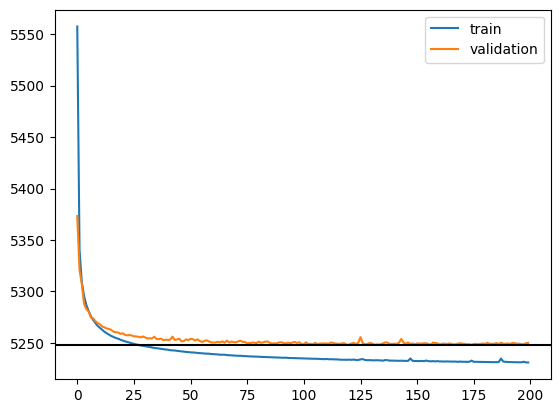

In [19]:
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

In [ ]:
adata.write_h5ad('temp.h5ad')

In [20]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [22]:
adata.obsm['X_scVI'].shape

(300349, 10)

In [23]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [25]:
sc.tl.leiden(adata, resolution = 3, key_added = 'overcluster')

In [27]:
sc.tl.umap(adata)

In [28]:
adata.layers['counts'] = adata.X.copy()

In [29]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
adata.write_h5ad('temp.h5ad')

In [32]:
adata.obs['low_major'] = adata.obs.groupby('overcluster')['low_label'].transform(lambda x: x.mode()[0])

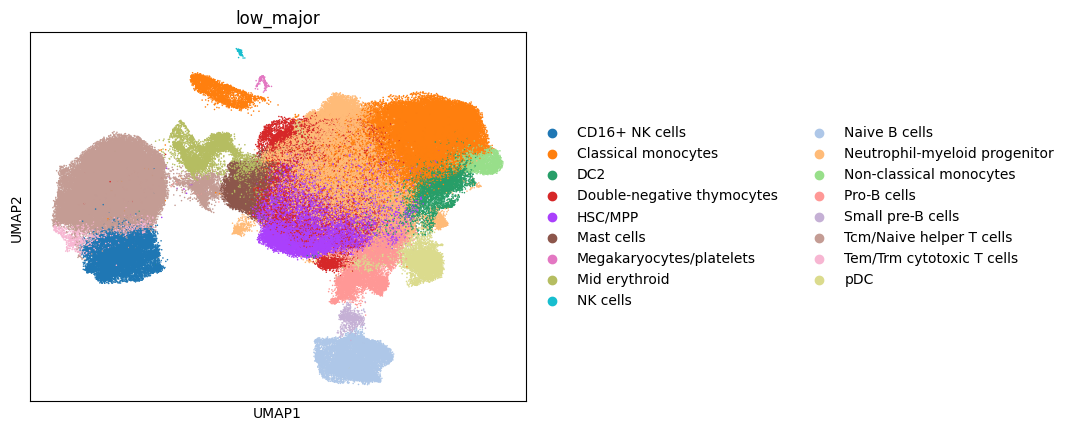

In [33]:
sc.pl.umap(adata, color = ['low_major'], s = 5)

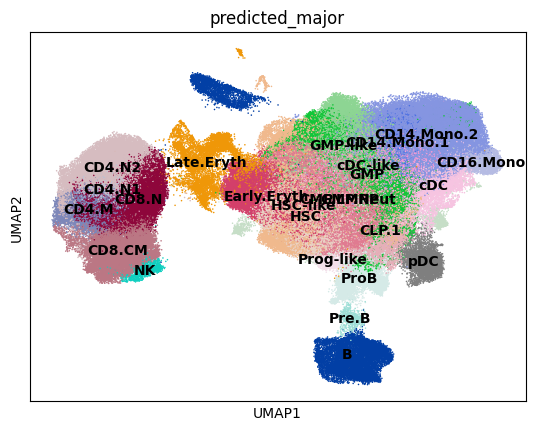

In [34]:
adata.obs['predicted_major'] = adata.obs.groupby('overcluster')['predicted'].transform(lambda x: x.mode()[0])

sc.pl.umap(adata, color = ['predicted_major'], legend_loc = 'on data', s = 5)

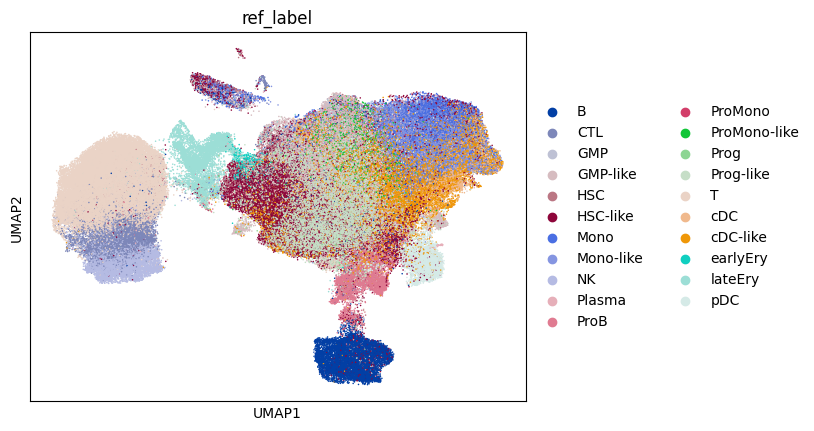

In [35]:
adata.obs['ref_major'] = adata.obs.groupby('overcluster')['ref_label'].transform(lambda x: x.mode()[0])

sc.pl.umap(adata, color = ['ref_label'], s = 5)

# Annotation

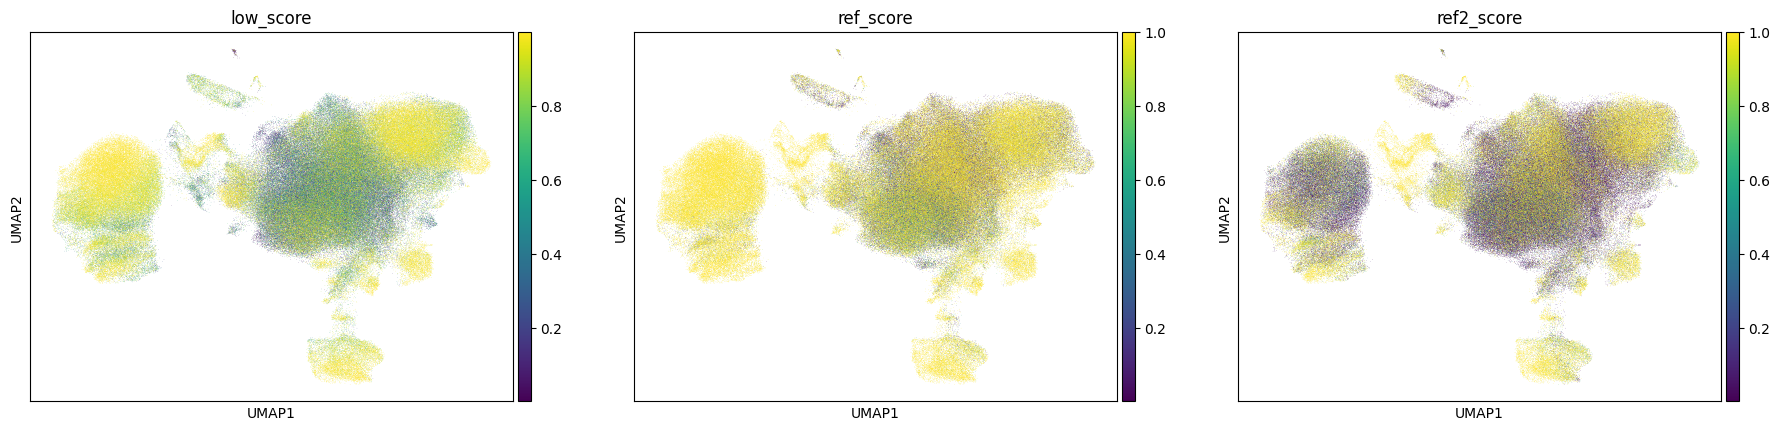

In [36]:
sc.pl.umap(adata, color = ['low_score', 'ref_score', 'ref2_score' ])

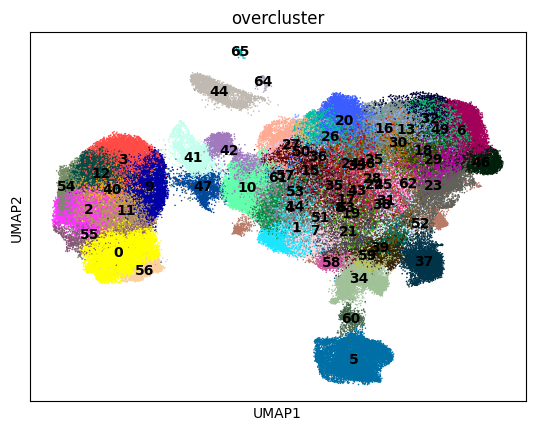

In [37]:
sc.pl.umap(adata, color = ['overcluster'], legend_loc = 'on data', s = 5)

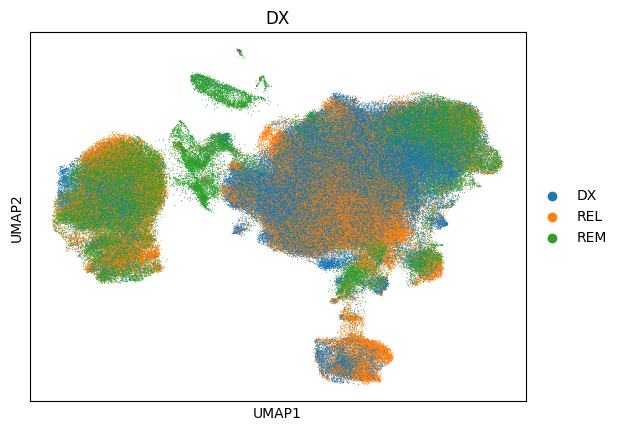

In [38]:
np.random.seed(1)
ri = np.random.permutation(list(range(adata.shape[0])))

sc.pl.umap(adata[ri,:], color = ['DX'], vmin = .5, size = 2)

In [39]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9506284/
#https://www.pnas.org/doi/pdf/10.1073/pnas.2003900117

aml_marks = ['CD33', 'CD44', 'CD47', 'BST1', 'CD244', 'HAVCR2', 'CLEC12A', 'IL1RAP', 'MPO', 'AZU1', 'ELANE', 'PRTN3', 
            'CLEC11A', 'PRAME', 'NREP', 'ARMH1', 'C1QBP', 'TRH']


sc.tl.score_genes(adata, aml_marks, score_name = 'AML_blast_score')

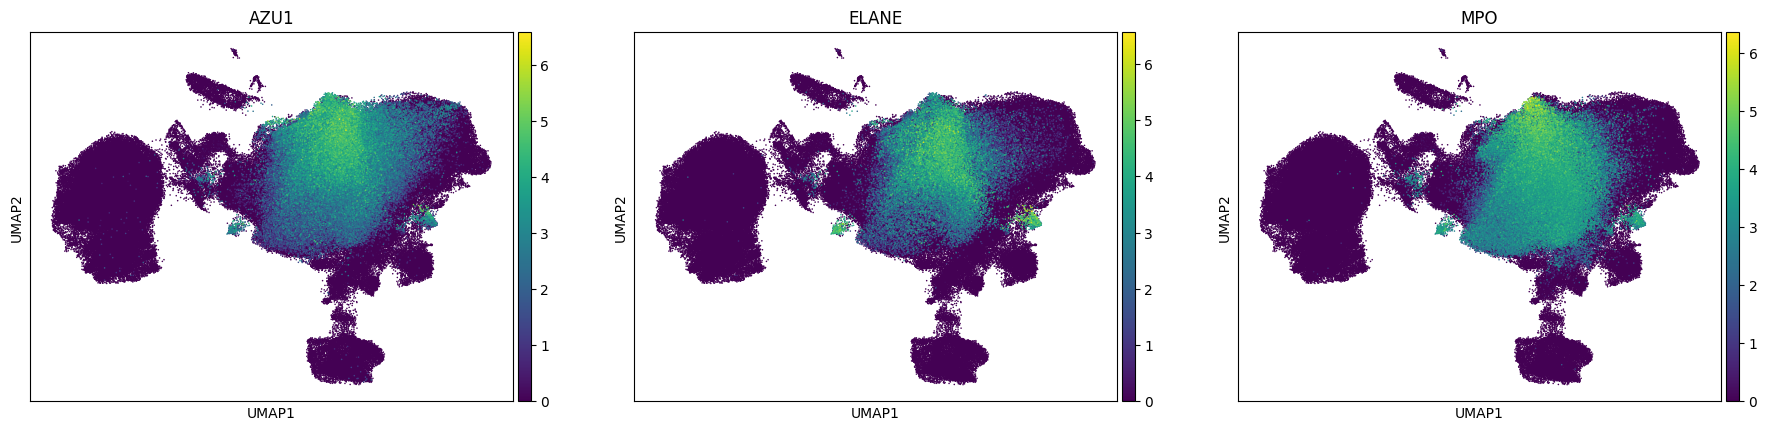

In [40]:
sc.pl.umap(adata, color = ['AZU1', 'ELANE', 'MPO'], s = 5)

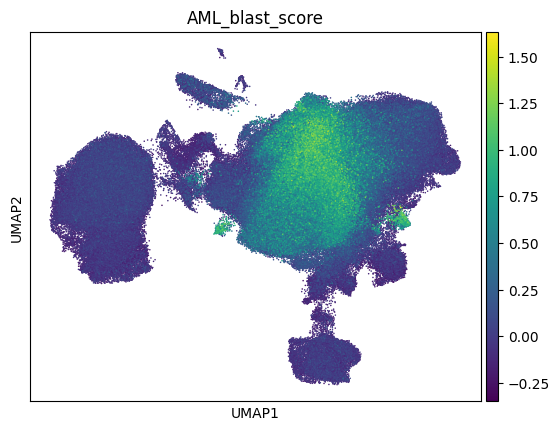

In [41]:
sc.pl.umap(adata, color = ['AML_blast_score'], s = 5)

In [42]:
aml_blast_scores = adata.obs[['overcluster', 'AML_blast_score']].groupby('overcluster').median()

<Axes: xlabel='overcluster', ylabel='AML_blast_score'>

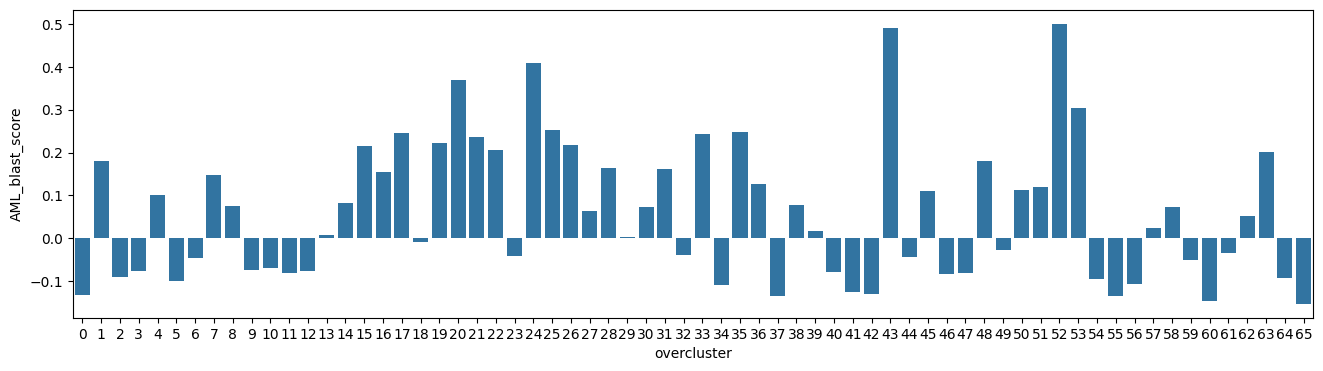

In [44]:
plt.figure(figsize = (16, 4))
sns.barplot(aml_blast_scores, y = 'AML_blast_score', x = aml_blast_scores.index)

In [45]:
labels = adata.obs[['low_label', 'ref_label', 'ref2_label', 'predicted','overcluster']].groupby('overcluster').agg(lambda x: x.mode())
scores = adata.obs[['low_score', 'ref_score', 'ref2_score','transfer_score','overcluster']].groupby('overcluster').agg(lambda x: x.mean())

mapping_res = labels.merge(right = scores, left_index=True, right_index=True)

In [88]:
mapping_res[40:50]

low_label  ref_label      ref2_label  \
overcluster                                                             
40                Tcm/Naive helper T cells          T       21_CD4.N2   
41                           Mid erythroid    lateEry   03_Late.Eryth   
42                           Mid erythroid    lateEry   03_Late.Eryth   
43           Neutrophil-myeloid progenitor   GMP-like     08_GMP.Neut   
44                     Classical monocytes   HSC-like  12_CD14.Mono.2   
45                     Classical monocytes   cDC-like  12_CD14.Mono.2   
46                 Non-classical monocytes   cDC-like    13_CD16.Mono   
47                Tcm/Naive helper T cells    lateEry   03_Late.Eryth   
48                     Classical monocytes   cDC-like            17_B   
49                     Classical monocytes  Mono-like  12_CD14.Mono.2   

               predicted  low_score  ref_score  ref2_score  transfer_score  
overcluster                                                                 
40                CD4.N1   0.964791   0.980608    0.279939        0.914714  
41            Late.Eryth   0.811064   0.996394    0.998696        0.969359  
42            Late.Eryth   0.782480   0.775955    0.886610        0.971583  
43              GMP.Neut   0.483528   0.691535    0.532164        0.925160  
44                     B   0.702154   0.544124    0.449953        0.985155  
45              cDC-like   0.320454   0.357452    0.123151        0.915570  
46             CD16.Mono   0.967654   0.700417    0.704498        0.994551  
47            Late.Eryth   0.528499   0.856315    0.864205        0.935238  
48                   GMP   0.470039   0.592594    0.205825        0.923858  
49           CD14.Mono.2   0.916921   0.847386    0.735044        0.959181

In [54]:
sc.tl.rank_genes_groups(adata, groupby = 'overcluster')
marks = sc.get.rank_genes_groups_df(adata, group = None)

In [55]:
marks

group    names      scores  logfoldchanges  pvals  pvals_adj
0           0    HLA-B  236.742691        1.942523    0.0        0.0
1           0     NKG7  220.726761        5.321103    0.0        0.0
2           0     CCL5  200.138092        5.461651    0.0        0.0
3           0    HLA-C  200.065216        2.085589    0.0        0.0
4           0      B2M  165.315521        1.427652    0.0        0.0
...       ...      ...         ...             ...    ...        ...
1396291    65     A1BG -258.354767      -27.394867    0.0        0.0
1396292    65    SYTL1 -261.925568      -27.513292    0.0        0.0
1396293    65  ALOX5AP -275.546906      -28.285286    0.0        0.0
1396294    65   SAMSN1 -294.376343      -28.066748    0.0        0.0
1396295    65  SLC38A1 -295.444458      -28.156713    0.0        0.0

[1396296 rows x 6 columns]

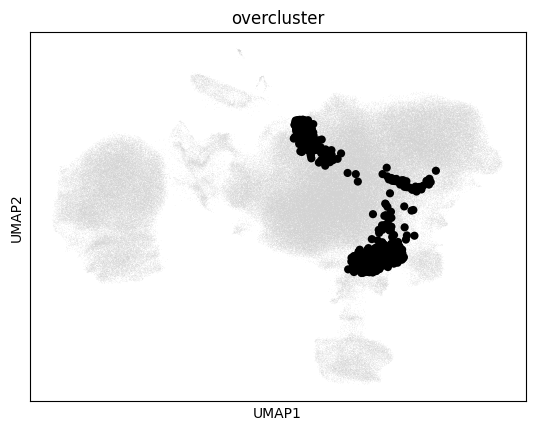

In [96]:
ax = sc.pl.umap(adata, palette = 'lightgrey', show = False)
sc.pl.umap(adata[adata.obs.overcluster == '59'], color = 'overcluster', ax = ax, legend_loc = None, palette = 'k')

In [97]:
_ = adata.obs.groupby(['overcluster', 'DX']).size().reset_index()
_[_.overcluster == '59']

overcluster   DX    0
177          59   DX  205
178          59  REL  328
179          59  REM  336

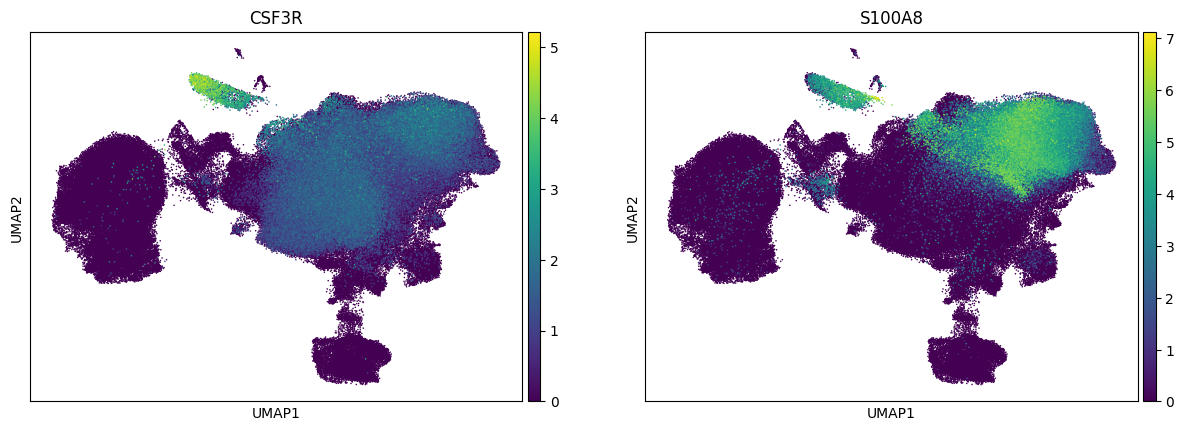

In [94]:
sc.pl.umap(adata, color = ['CSF3R', 'S100A8'], legend_loc = 'on data', s = 5)

In [86]:
marks[(marks.names == 'TPSAB1') ].sort_values('logfoldchanges', ascending = False).head()

group   names     scores  logfoldchanges         pvals     pvals_adj
211565     10  TPSAB1  87.712479        5.592444  0.000000e+00  0.000000e+00
84714       4  TPSAB1  52.446213        2.482129  0.000000e+00  0.000000e+00
296333     14  TPSAB1  42.197929        2.235497  0.000000e+00  0.000000e+00
1121485    53  TPSAB1  14.254958        1.796557  7.824700e-43  8.411552e-42
21456       1  TPSAB1  39.399048        1.649755  0.000000e+00  0.000000e+00

In [99]:
marks[(marks.group == '59')].head(10)

group    names     scores  logfoldchanges          pvals  \
1248204    59   TUBA1B  85.918053        3.541741   0.000000e+00   
1248205    59    H2AFZ  78.306709        2.916618   0.000000e+00   
1248206    59    PCLAF  75.170197        4.453035   0.000000e+00   
1248207    59     TUBB  74.742096        3.131462   0.000000e+00   
1248208    59     CD74  68.952667        2.297455   0.000000e+00   
1248209    59    HMGN2  66.126389        2.594371   0.000000e+00   
1248210    59    GAPDH  62.795666        1.316903   0.000000e+00   
1248211    59    STMN1  61.278427        3.630430  2.703942e-318   
1248212    59  SLC25A5  58.257256        1.580897  1.406951e-304   
1248213    59    HMGB2  57.884323        3.023342  3.698718e-301   

             pvals_adj  
1248204   0.000000e+00  
1248205   0.000000e+00  
1248206   0.000000e+00  
1248207   0.000000e+00  
1248208   0.000000e+00  
1248209   0.000000e+00  
1248210   0.000000e+00  
1248211  5.500442e-316  
1248212  2.681572e-302  
1248213  6.745696e-299

In [98]:
aml_blast_scores[aml_blast_scores.index == '59']

AML_blast_score
overcluster                 
59                 -0.050902

In [100]:
over2cell = {"0":"NK",
"1":"AML-blast",
"2":"Th",
"3":"Th",
"4":"AML-blast",
"5":"B",
"6":"Mono",
"7":"AML-blast",
"8":"AML-blast",
"9":"Tc",
"10":"Mast",
"11":"Tc",
"12":"Th",
"13":"Mono",
"14":"AML-blast",
"15":"AML-blast",
"16":"AML-blast",
"17":"AML-blast",
"18":"Mono",
"19":"AML-blast",
"20":"AML-blast",
"21":"AML-blast",
"22":"AML-blast",
"23":"DC",
"24":"AML-blast",
"25":"AML-blast",
"26":"AML-blast",
"27":"AML-blast",
"28":"AML-blast",
"29":"AML-blast",
"30":"Mono",
"31":"AML-blast",
"32":"Mono",
"33":"AML-blast",
"34":"ProB",
"35":"AML-blast",
"36":"AML-blast",
"37":"pDC",
"38":"AML-blast",
"39":"ProB",
"40":"Th",
"41":"erythroid",
"42":"erythroid",
"43":"AML-blast",
"44":"Neutrophil",
"45":"AML-blast",
"46":"NC-Mono",
"47":"erythroid",
"48":"AML-blast",
"49":"Mono",
"50":"AML-blast",
"51":"AML-blast",
"52":"AML-blast",
"53":"AML-blast",
"54":"Th",
"55":"Tc",
"56":"NK",
"57":"HSC-like", 
"58":"AML-blast",
"59":"Unk", #at the end of the day, there may be some small clusters that are almost impossible to annotate
"60":"PreB",
"61":"AML-blast",
"62":"AML-blast",
"63":"AML-blast",
"64":"Platelets",
"65":"Unk2"}

In [101]:
adata.obs['CellType'] = adata.obs.overcluster.map(over2cell)

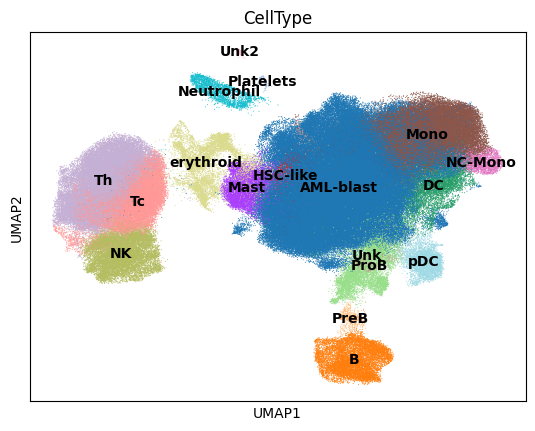

In [102]:
sc.pl.umap(adata, color = ['CellType'], s = 2, legend_loc = 'on data')

In [103]:
adata.write_h5ad('annotated.h5ad')

In [ ]:
#for thumbnail

In [5]:
adata = sc.read_h5ad('annotated.h5ad')

In [6]:
sc.set_figure_params(dpi_save=600, transparent=True)

In [7]:
from matplotlib.pyplot import rc_context

In [8]:
adata = adata[~adata.obs.CellType.str.contains('Unk')]

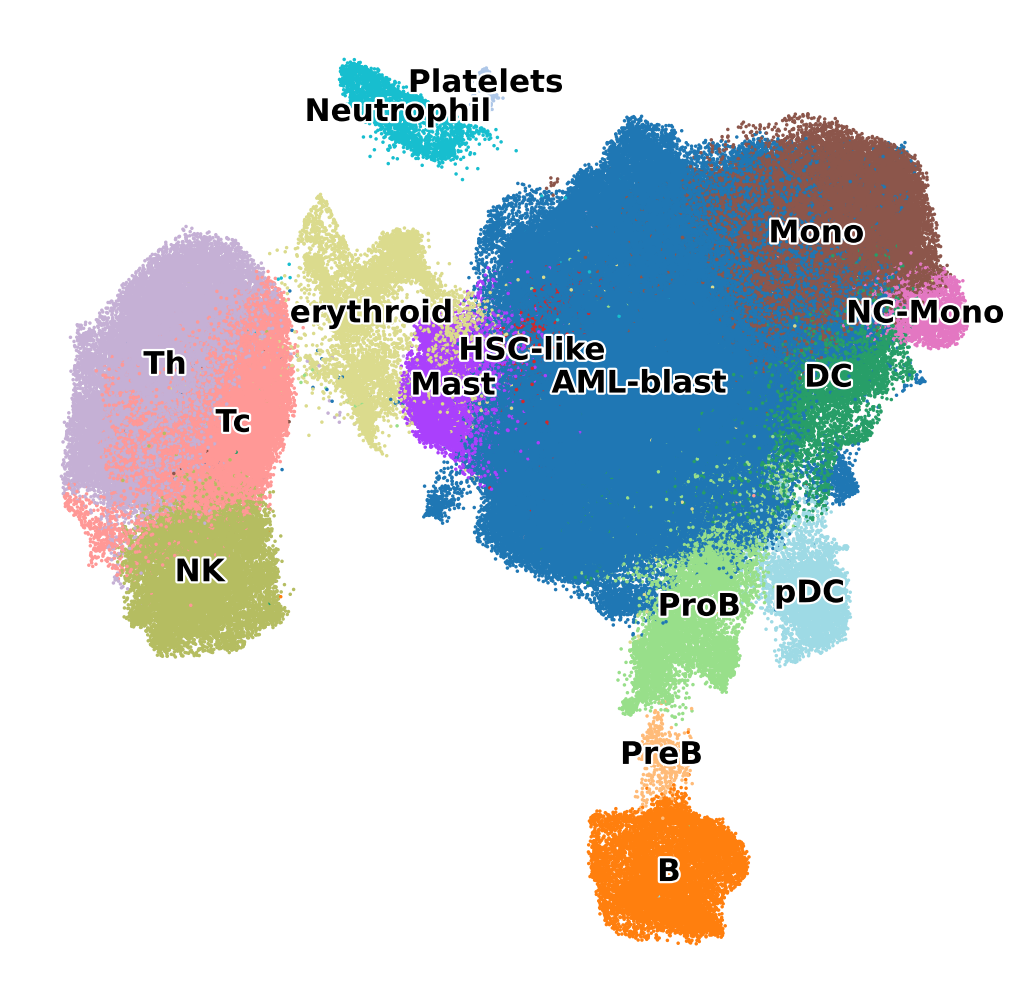

In [31]:
with rc_context({"figure.figsize": (8, 8)}):
    sc.pl.umap(adata, color = ['CellType'], s = 10, legend_loc = 'on data',
        legend_fontsize=14,
        legend_fontoutline=2,
        frameon=False, title = '', save = 'cells.png')

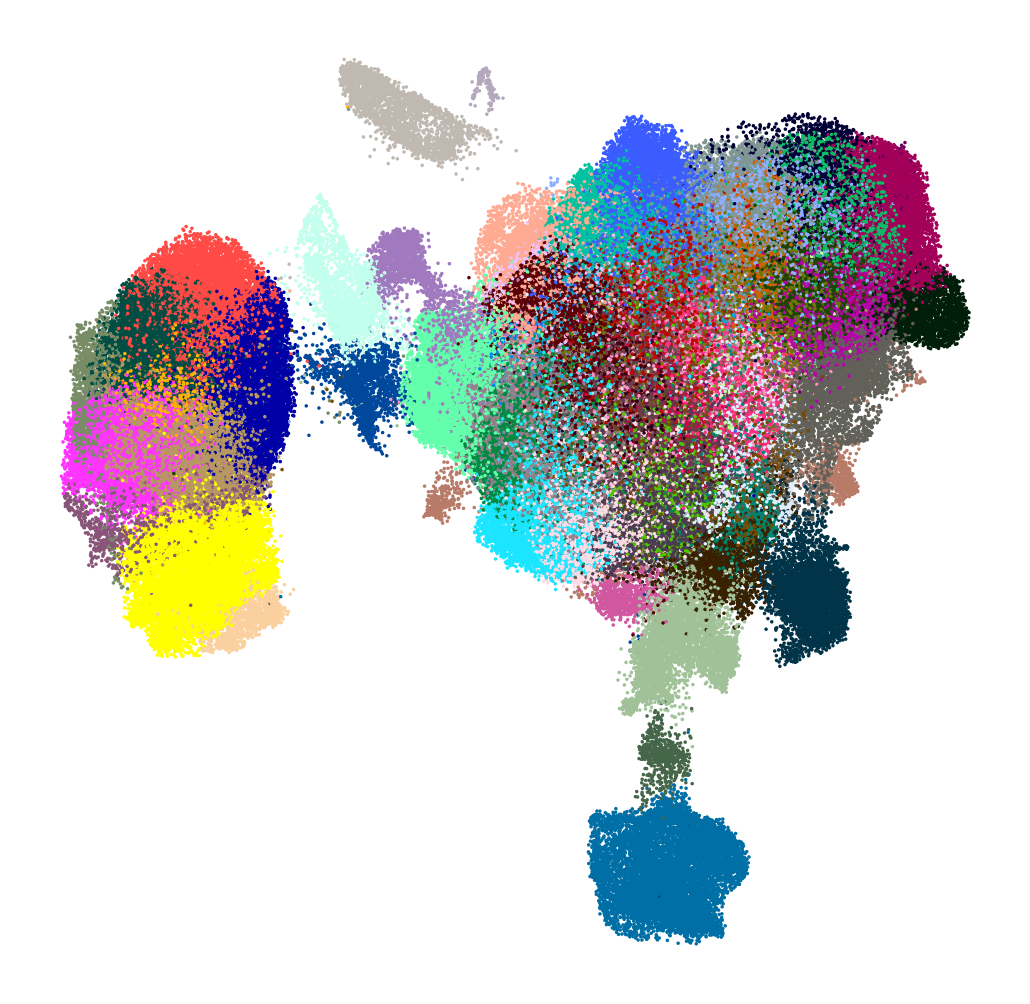

In [33]:
with rc_context({"figure.figsize": (8, 8)}):
    sc.pl.umap(adata, color = ['overcluster'], s = 10, legend_loc = None,
        legend_fontsize=14,
        legend_fontoutline=2,
        frameon=False, title = '', save = 'clusters.png')